# References 

code - https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/gan/dcgan/__init__.py- released under the MIT license.

implementation of paper
[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).


In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from IPython import display as disp
from torch import optim
from torch import utils
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchsummary import summary



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
device

device(type='cuda')

In [3]:
# helper function to make getting another batch of data easier
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform = transform),
    batch_size=128, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform = transform),
    batch_size=128, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


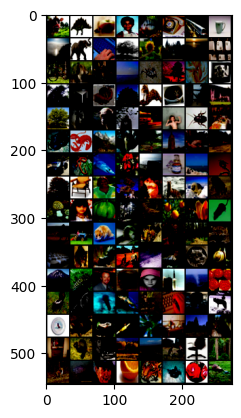

In [4]:
# view some of the training data
plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

In [5]:
class Generate(nn.Module):

    def __init__(self, noise=300):
        super(Generate, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(noise, 64 * 2, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # Maintain feature maps, adjust for size
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        out = self.classifier(x)
        return out

    def sample(self,z):
        samples = self.forward(z)
        return samples

class Discriminate(nn.Module):
    def __init__(self):
        super(Discriminate, self).__init__()
        # Reduce feature maps across layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=4, stride=2, padding=1),  # From 64 to 32 feature maps
            nn.LeakyReLU(negative_slope=1e-2, inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=4, stride=2, padding=1),  # Adjusted feature maps
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=1e-2, inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Further adjusted
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=1e-2, inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),  # Adjust stride & padding for size
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        out = self.classifier(x)
        out = out.view(-1, 1).squeeze(1)
        return out


In [6]:
criterion = nn.BCELoss().to(device)
G = Generate().to(device)
D = Discriminate().to(device)


d_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999),weight_decay=2e-5)
g_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999),weight_decay=2e-5)

step_scheduler_gen = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=50, gamma=0.5)
step_scheduler_disc = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=50, gamma=0.5)


print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(D.parameters()))}')
if len(torch.nn.utils.parameters_to_vector(D.parameters())) > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
if len(torch.nn.utils.parameters_to_vector(G.parameters())) > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

steps = 0
#summary(G, (300, 256, 256))

> Number of model parameters 185201
> Number of model parameters 814851


steps 50000.00, G_loss: 4.093, D_loss: 0.235


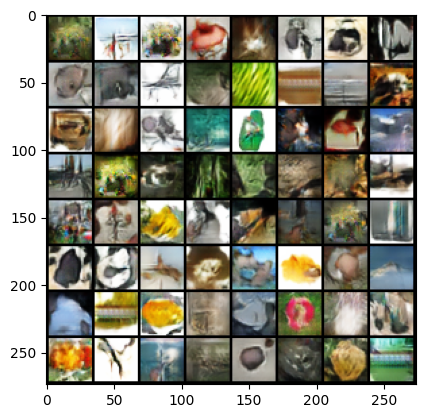

In [7]:
noise_D = 300
while (steps < 50000):

    # arrays for metrics
    loss_DIS_arr = np.zeros(0)
    loss_generator_arr = np.zeros(0)
    real_labels = torch.ones(128,).to(device)
    fake_labels = torch.zeros(128,).to(device)

    # iterate over some of the train dateset
    for i in range(1000):
      D.zero_grad()
      x,t = next(train_iterator)
      x,t = x.to(device), t.to(device)

      P = D(x)
      d_loss_real = criterion(P, real_labels)
      d_loss_real.backward()
      real_score = P.mean().item()

      noise = torch.randn(128, noise_D, 1, 1).to(device)
      fake = G(noise)
      P = D(fake.detach())
      d_loss_fake = criterion(P, fake_labels)
      d_loss_fake.backward()
      fake_score_z1 = P.mean().item()

      d_loss = d_loss_real + d_loss_fake
      d_optimizer.step()

      G.zero_grad()
      P = D(fake)
      g_loss = criterion(P, real_labels)
      g_loss.backward()
      fake_score_z2 = P.mean().item()
      g_optimizer.step()

      steps += 1

      loss_DIS_arr = np.append(loss_DIS_arr, d_loss.item())
      loss_generator_arr = np.append(loss_generator_arr, g_loss.item())

    print('steps {:.2f}, G_loss: {:.3f}, D_loss: {:.3f}'.format(steps, loss_generator_arr.mean(),loss_DIS_arr.mean()))

    # sample model and visualise results
    G.eval()
    z = torch.randn(64, noise_D, 1, 1).to(device)
    samples = G.sample(z).cpu().detach()
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)
    plt.imshow(torchvision.utils.make_grid(samples).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
    plt.show()
    disp.clear_output(wait=True)
    G.train()

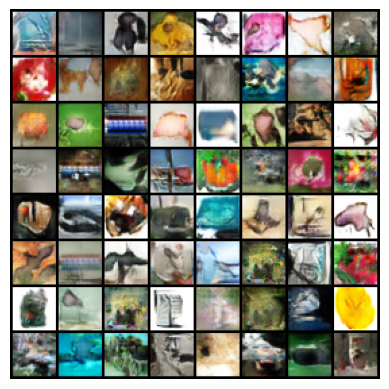

In [8]:
G.eval()
z = torch.randn(64, noise_D, 1, 1).to(device)
samples = G.sample(z).cpu().detach()

# Rescale images from [-1, 1] to [0, 1]
samples = (samples + 1) / 2

# Ensure no pixel value falls outside [0, 1]
samples = samples.clamp(0, 1)

# Display images
#plt.figure(figsize=(10, 10))
plt.imshow(torchvision.utils.make_grid(samples,nrow= 8).numpy().transpose(1, 2, 0))
plt.axis('off')  # Hide axes for better visualization
plt.show()
disp.clear_output(wait=True)
G.train()
plt.show()

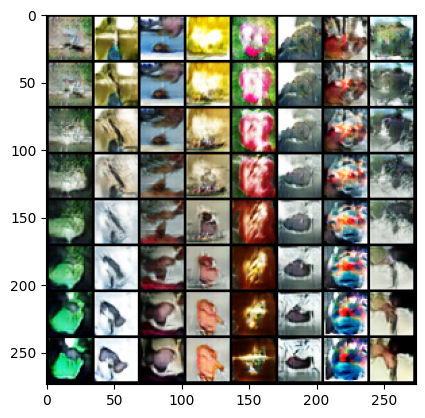

In [9]:
# interpolations 
col_size = int(np.sqrt(64))
z = torch.randn(64, noise_D, 1, 1).to(device)
z0 = z[0:col_size].repeat(col_size, 1, 1, 1) # z for top row
z1 = z[-col_size:].repeat(col_size, 1, 1, 1)   # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(64,1,1,1).to(device)


 # linearly interpolate between two points in the latent space
lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = G.sample(lerp_z) # sample the model at the resulting interpolated latents

samples = (lerp_g + 1) / 2

# Ensure no pixel value falls outside [0, 1]
samples = samples.clamp(0, 1)
plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(samples).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

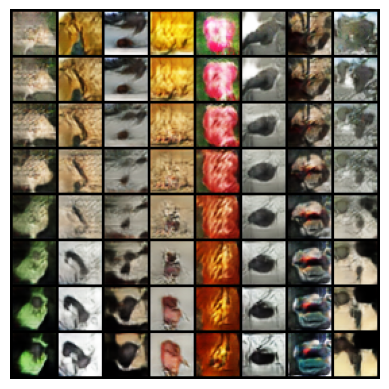

In [13]:
def slerp(val, low, high):
    """Perform Spherical Linear Interpolation (slerp) between low and high with val as interpolation factor."""
    omega = torch.acos((low / torch.norm(low, dim=-1, keepdim=True)).clamp(-1, 1) * (high / torch.norm(high, dim=-1, keepdim=True)).clamp(-1, 1))
    sin_omega = torch.sin(omega)
    if torch.any(sin_omega == 0):
        return (1.0 - val) * low + val * high  # L'Hopital's rule/LERP
    else:
        return torch.sin((1.0 - val) * omega) / sin_omega * low + torch.sin(val * omega) / sin_omega * high

# Assuming z0, z1 are your starting and ending points in the latent space
# t is a tensor of values from 0 to 1 representing interpolation points

# Reshape t to match the dimensions required for slerp
t = torch.linspace(0, 1, col_size).unsqueeze(-1).to(device)
t = t.repeat(1, col_size).view(64, 1, 1, 1)

# Perform slerp interpolation
lerp_z = torch.zeros_like(z0)
for i in range(z0.shape[0]):
    lerp_z[i] = slerp(t[i], z0[i], z1[i])

# Generate images from the interpolated latent vectors
G.eval()
with torch.no_grad():
    lerp_g = G(lerp_z)  # Assume G is your generator model

# Normalize and display the images
samples = (lerp_g + 1) / 2
samples = samples.clamp(0, 1)
plt.imshow(torchvision.utils.make_grid(samples, nrow=col_size).cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [10]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [11]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory} # remove any existing (old) data
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    z = torch.randn(100, noise_D, 1, 1).to(device)
    samples_batch = G.sample(z).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

In [12]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")

compute FID between two folders
Found 10000 images in the folder real_images


FID real_images : 100%|██████████| 313/313 [00:22<00:00, 13.91it/s]


Found 10000 images in the folder generated_images


FID generated_images : 100%|██████████| 313/313 [00:21<00:00, 14.48it/s]


FID score: 31.562631872324687


In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install lpips
import lpips

In [18]:
# Initialize LPIPS model
lpips_model = lpips.LPIPS(net='alex')  # Using AlexNet
lpips_model = lpips_model.to(device)

# Function to compute LPIPS similarity
def compute_lpips_similarity(img1, img2):
    # img1 and img2 should be normalized in the range [-1, 1] and of shape [B, C, H, W]
    return lpips_model(img1, img2)

# Example usage with two images
z = torch.randn(2, noise_D, 1, 1).to(device)  # Generate two noise samples
with torch.no_grad():
    imgs = G(z)  # Generate images
imgs = (imgs + 1) / 2  # Normalize images to [0, 1] for visualization

similarity = compute_lpips_similarity(imgs[0:1], imgs[1:2])  # Compute LPIPS similarity between two images
print(f"LPIPS Similarity: {similarity.item()}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS Similarity: 0.14615221321582794


In [17]:
device

device(type='cuda')

In [ ]:
z = torch.randn(128, noise_D, 1, 1).to(device)
with torch.no_grad():
    generated_images = G(z)

# Evaluate the images using the discriminator
disc_scores = D(generated_images).detach().cpu()

# Pick the top N images with the highest scores
N = 20  # Number of images to pick
_, top_indices = torch.topk(disc_scores.view(-1), N)

# Select and visualize the top N images
top_images = generated_images[top_indices]
samples = (top_images + 1) / 2
samples = samples.clamp(0, 1)
plt.figure(figsize=(20, 2))  # Adjust figure size to accommodate a single row of images
plt.imshow(torchvision.utils.make_grid(samples, nrow=top_images.size(0)).cpu().numpy().transpose(1, 2, 0))
plt.axis()
#plt.show()


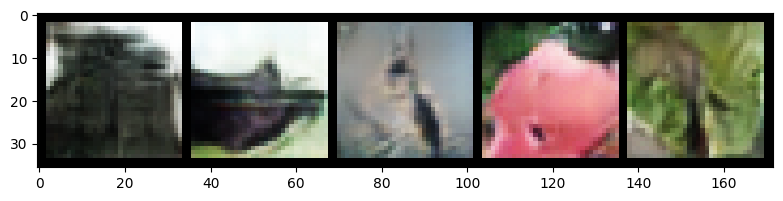

In [53]:
N = 5
_, top_indices = torch.topk(disc_scores.view(-1), N)
top_images = generated_images[top_indices]
samples = (top_images + 1) / 2
samples = samples.clamp(0, 1)
plt.figure(figsize=(20, 2))  # Adjust figure size to accommodate a single row of images
plt.imshow(torchvision.utils.make_grid(samples, nrow=top_images.size(0)).cpu().numpy().transpose(1, 2, 0))
plt.axis()
plt.show()